<a href="https://www.kaggle.com/fangya/cryptocurrency-data-visualization-arima?scriptVersionId=86681052" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

info = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/train.csv")

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


## 1. Introduction

Crypto, a form of digital token or “coins” that exist on a distributed and decentralized ledger called a blockchain, is a popular investment nowadays.

A crypto is a collection of binary data which is designed to work as a medium of exchange. Individual coin ownership records are stored in a ledger, which is a computerized database using strong cryptography to secure transaction records, to control the creation of additional coins, and to verify the transfer of coin ownership.

*KEY idea: Decentralization, Blockchain

This project consisite of three parts: 
1. Data visualtion for 14 popular cryptocurrency
2. Price History for selected individual cryptocurrency
3. Basic Arima Model for price prediction

In [2]:
ctrain.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [3]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

# Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()

60    1803769
Name: timestamp, dtype: int64

In [4]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [5]:
# Data Selection
def crypto_sub(asset_id ,data= ctrain ):
    df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

#Subgroup Bitcoin
btc1=crypto_sub(asset_id=1)

#Subgroup Eth
eth1=crypto_sub(asset_id=6)

#Subgroup Ada
ada1=crypto_sub(asset_id=3)


## 2. Data Visualization
we will present the weight among the 14 different crypto currency and investigate three crypto currency in depth.

#### Cryptocurrency summary:

0. Bitcoin (BTC): launched in January 2009. It introduced a novel idea set out in a white paper by the mysterious Satoshi Nakamoto—bitcoin offers the promise of an online currency that is secured without any central authority, unlike government-issued currencies.


1. Ethereum (ETH): The goal behind Ethereum is to create a decentralized suite of financial products that anyone in the world can freely access, regardless of nationality, ethnicity, or fait.


3. Litecoin(LTC): known as “silver to Bitcoin’s gold.” It is Based on an open-source global payment network that is not controlled by any central authority and uses “scrypt” as a proof of work, which can be decoded with the help of consumer-grade CPUs.


4. Cardano (ADA)：an “Ouroboros proof-of-stake” cryptocurrency that was created with a research-based approach by engineers, mathematicians, and cryptography experts.


5. Bitcoin Cash (BCH): an important place in the history of altcoins because it is one of the earliest and most successful hard forks of the original Bitcoin


6. Stella(XLM): an open blockchain network designed to provide enterprise solutions by connecting financial institutions for the purpose of large transactions.(Transcations between banks)


7. Dogecoin(DOGE): as the original "memecoin" caused a stir in 2021 as the price of the coin skyrocketed. (Popular because of Elon Musk)


8. Binance Coin(BNB): a utility cryptocurrency that operates as a payment method for the fees associated with trading on the Binance Exchange. It is the third-largest cryptocurrency by market capitalization. (initiated from ETH)


9. Monero(XMR): a secure, private, and untraceable currency.The development of this cryptocurrency is completely donation-based and community-driven.


10. TRON: Founded in 2017 by a Singapore non-profit organization, aims to host a global entertainment system for the cost-effective sharing of digital content.


11. IOTA: a distributed ledger designed to record and execute transactions between machines and devices in the Internet of Things (IoT) ecosystem.


12. EOS.IO: a blockchain-based, decentralized platform used to develop, host, and run business applications, or dApps.


13. Ethererum Classic: an open-source, decentralized, blockchain-based distributed cryptocurrency platform that runs smart contracts. It is as a split version of ETH.


### 2.1 Weight Distribution Plot
The Bar plot shows Bitcoin, Ethereum, and Cardano are the three most popular crypto currency for trading or investment

In [6]:
%matplotlib inline
info_s=info.sort_values("Weight")
fig_index=px.bar(info_s,x="Asset_Name" , y="Weight", color="Weight", title="Popular Cryptocurrency Weight Distribution")
fig_index.show()

### 2.2 Cryptocurrency Log Return Correlation Plot for 2021
From the Correlation plot we can see Bitcoin Cash is highly correlated with EOS.IO.

Binance Coin is correlated with many crypto currencies, such as , Bitcoin, Bitcoin Cash, Cardano, Ethereum. 

We can have a roughly conclude that Binance Coin, Bitcoin Cash prices have a strong relation with other cryptocurrencies. Whereas Dogecoin and Monero prices are quite independent. 
Ealier we mentioned Monero is based a donation, which makes sense it is not correlated so much with other coins.


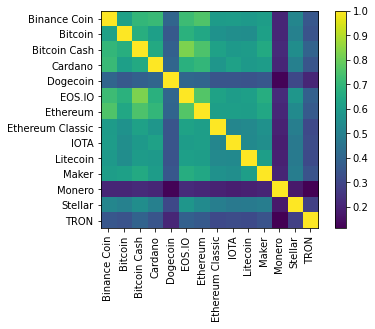

In [7]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

all2021=pd.DataFrame([])
for asset_id, asset_name in zip(info.Asset_ID, info.Asset_Name):
    asset=ctrain[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    asset=asset.loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]
    asset=asset.reindex(range(asset.index[0],asset.index[-1]+60,60), method="pad")
    lret=log_return(asset.Close.fillna(0))[1:]
    all2021=all2021.join(lret,rsuffix=asset_name,how="outer")
    
plt.imshow(all2021.corr());
plt.yticks(info.Asset_ID, info.Asset_Name.values)
plt.xticks(info.Asset_ID, info.Asset_Name.values,rotation="vertical");
plt.colorbar()

## 3. Price History

We will use the Closing Price and Candlestick graph to capture the trends of the crypto currency.

 ### 3.1 Closing Price Trend in 2021 

we will impute the missing time value using the "pad" method and present the overall closing price for Bitcoin, Etherum, Carnado 
 

In [8]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

In [9]:
#1. Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [10]:
#2. Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
eth.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [11]:
#3. Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()
ada.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1523956260,3,16.0,0.260000,0.260990,0.260000,0.260000,32230.832200,0.260200,-0.004612
1523956320,3,28.0,0.260000,0.260990,0.259852,0.260000,18711.228600,0.260037,0.000387
1523956380,3,9.0,0.260000,0.260000,0.258700,0.258700,6831.405700,0.259515,-0.005415
1523956440,3,5.0,0.259999,0.259999,0.259870,0.259998,4414.874062,0.259884,-0.005415
1523956500,3,9.0,0.259997,0.259997,0.259000,0.259997,10797.813800,0.259997,0.000385


In [12]:
# Create time interval for 2021
def dur(start,end,data):
    df=data.loc[totimestamp(start): totimestamp(end)]
    return df

btc2021= dur(start="01/01/2021", end="21/09/2021", data=btc)
eth2021= dur(start="01/01/2021", end="21/09/2021", data=eth)
ada2021= dur(start="01/01/2021", end="21/09/2021", data=ada)

#### Investment Tips 1
We can see there is tremedeous price increase for BTC, ETH, and ADA in 2021, which implies they are all good investment

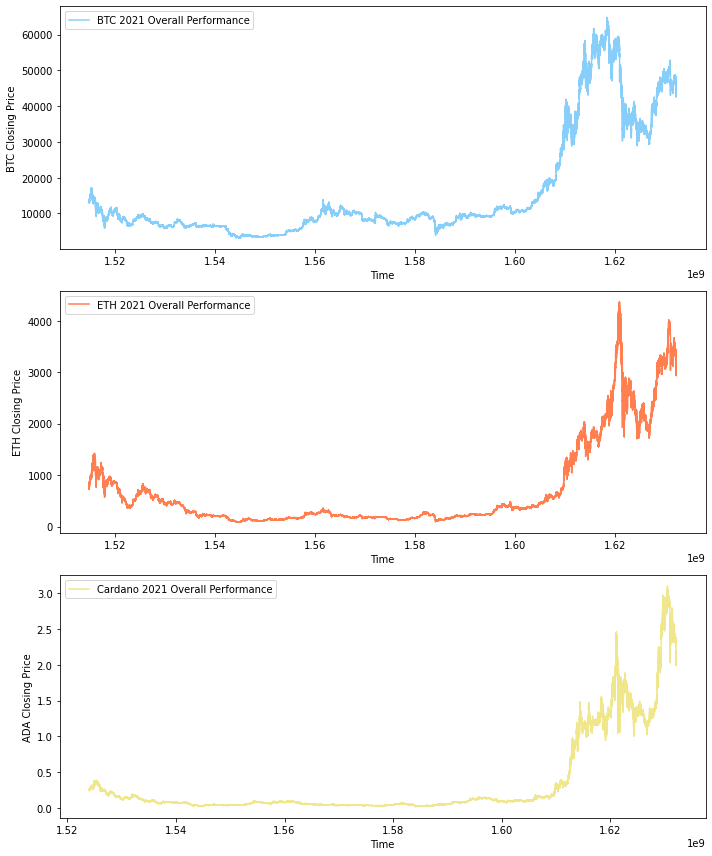

In [13]:
# Plot the Closing Price for BTC, ETH, ADA
f= plt.figure(figsize=(10,12))  

def gplot(no , data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc, price="Close" , label="BTC 2021 Overall Performance", ylabel="BTC Closing Price", color="Lightskyblue")
gplot(no=312, data=eth, price="Close" ,label="ETH 2021 Overall Performance", ylabel="ETH Closing Price", color="Coral")
gplot(no=313, data=ada, price="Close" ,label="Cardano 2021 Overall Performance", ylabel="ADA Closing Price", color="khaki")

plt.tight_layout()
plt.show()

### 3.2 Return Rate for BTC, ETH, and ADA
we see the crypto currency price went up dramatically regardless of the type, we would like to investigate one step further for the Target variable.
*Target : 15 minute resudualized returns.

*Residual Return: An asset's residual return equals its excess return minus beta times the benchmark excess return.

As we can see ETH, and BTC residual return are relatively stable compared to ADA.
This might be a good implication that if the investor would take short time trading opportunities, ADA is a better choice. 

If the investor is risk averse, BTC or ETH will be a better fit

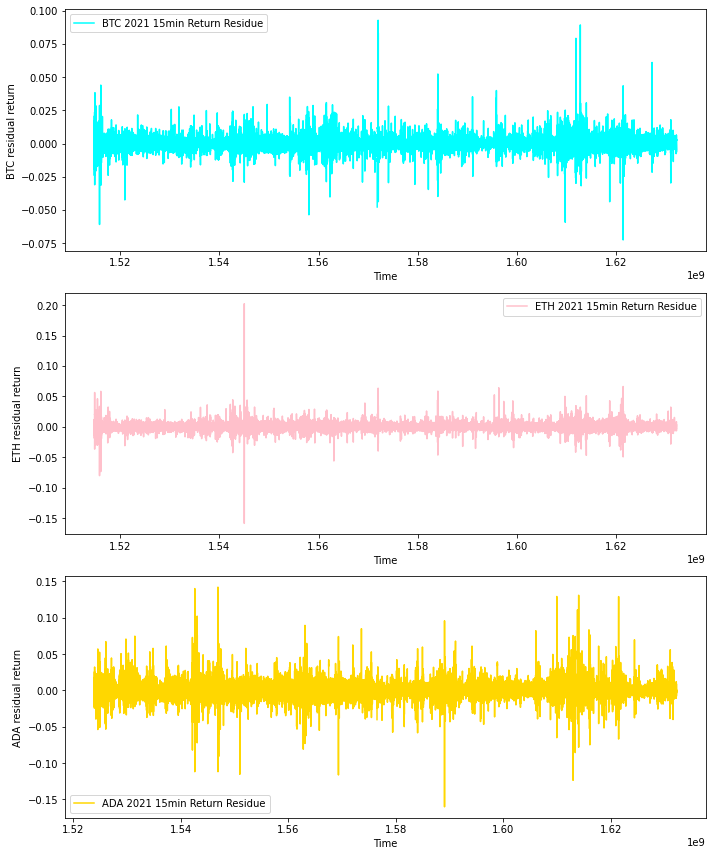

In [14]:
f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc, price="Target" , label="BTC 2021 15min Return Residue", ylabel="BTC residual return", color="Aqua")
gplot(no=312, data=eth, price="Target" ,label="ETH 2021 15min Return Residue", ylabel="ETH residual return", color="Pink")
gplot(no=313, data=ada, price="Target" ,label="ADA 2021 15min Return Residue", ylabel="ADA residual return", color="gold")


plt.tight_layout()
plt.show()

### 3.3 Candlestick Chart 
Candlestick charts are used by traders to determine possible price movement based on past patterns.

In [15]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(label),
        "y":0.8,
        "x":0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


#### Investment Tips 2
During the time interval 22:40 to 22:50, there is a series of downward red candle, which represent **Oversold.** Theoratically, the price would go up followed by a Oversold interval

**Oversold** means it's trading below what would be a typical or average trading range(sometimes the investors also call it as true value). Normally, oversold draw buyers in the market.


In [16]:
%matplotlib inline
btc_candle=c_chart(btc1[-90:], label="BTC Price")
btc_candle.show()

#### ETH Candlestick

We randomly pick a time interval for the ETh price, we see an over sold around 1:50am, and an overbuy around 02:05 am.

In [17]:
eth_candle=c_chart(eth1[100888:100988], label="ETH Price ")
eth_candle.show()

#### ADA Candle Stick

Overbuying around 16:20

In [18]:
%matplotlib inline
ada_candle=c_chart(eth1[-500:-400], label="ETH Price ")
ada_candle.show()

## 4. ARIMA Model 


In [19]:
# Function to Subset the Price variables
def mini_data(data):
    df=data[["Close","Low","High","Open"]]
    return df

btc1_mini=mini_data(btc1)
eth1_mini=mini_data(eth1)
ada1_mini=mini_data(ada1)
btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


#### 4.1 Seasonal Decomposition

BTC Seasonal Decomposition


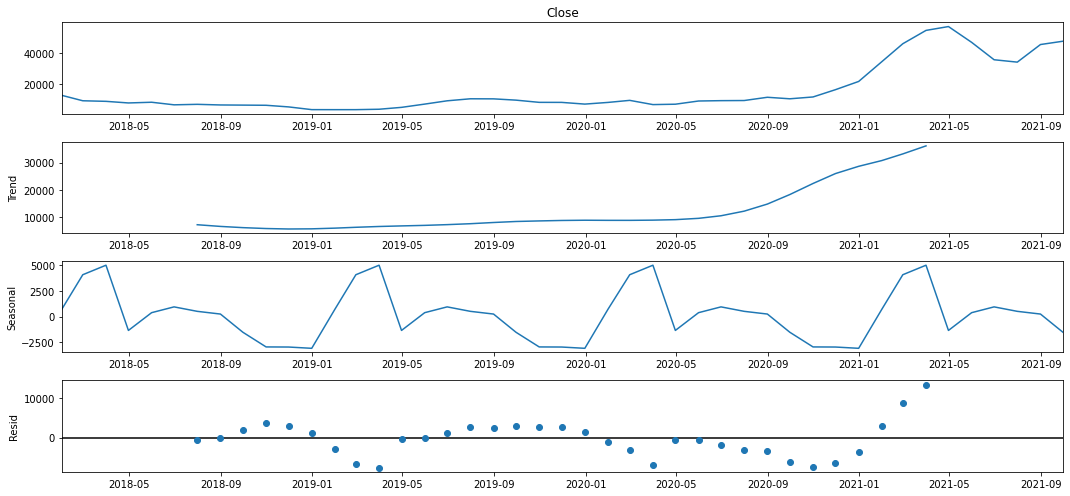

In [20]:
# Function to Plot
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label):
    df=data.resample("M").mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

season_df(data=btc1_mini, label="BTC Seasonal Decomposition")

ETH Seasonal Decomposition


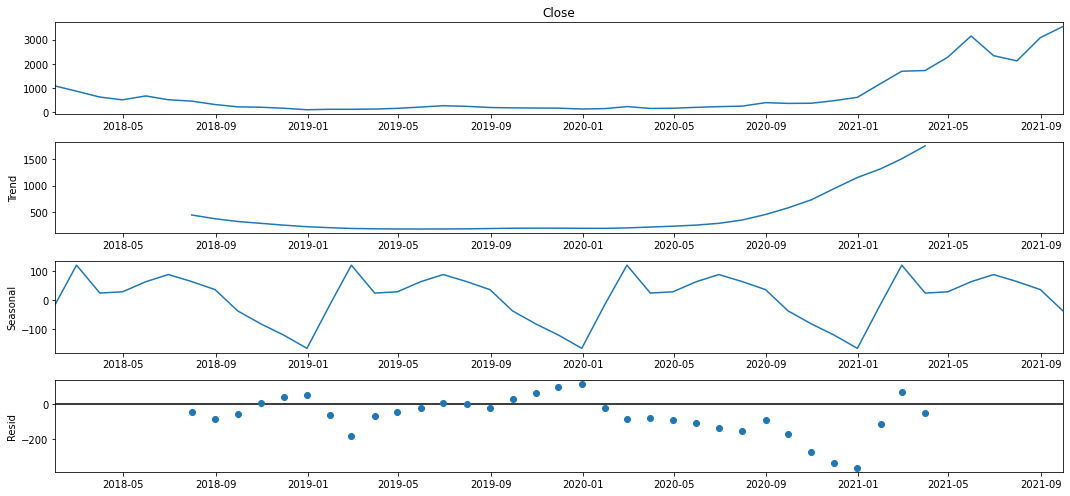

In [21]:
#ETH Seasonal Plot
season_df(data=eth1_mini, label="ETH Seasonal Decomposition")

ADA Seasonal Decomposition


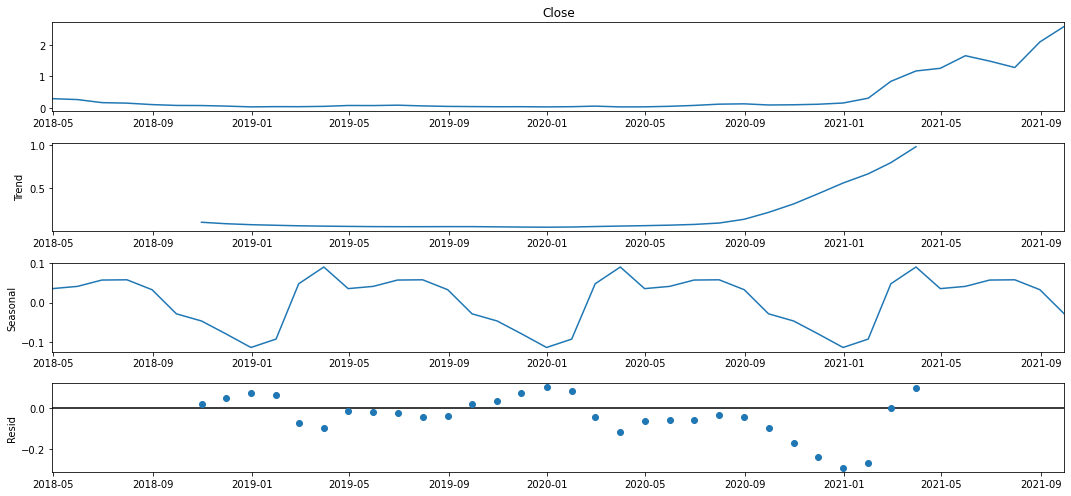

In [22]:
#ADA seasonal decompostion
season_df(data=ada1_mini, label="ADA Seasonal Decomposition")

#### 4.2 Box - Cox Transformation

In [23]:
#Box-Cox Transformation
btc_month=btc1_mini.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)

#btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)

In [24]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

  parameters         aic
3     (1, 0) -446.108784
1     (0, 1) -445.320473
6     (2, 0) -444.145557
4     (1, 1) -444.129630
2     (0, 2) -442.735686
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 225.054
Date:                Tue, 01 Feb 2022   AIC                           -446.109
Time:                        02:40:51   BIC                           -442.540
Sample:                    01-31-2018   HQIC                          -444.785
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3821      0.133      2.874      0.004      

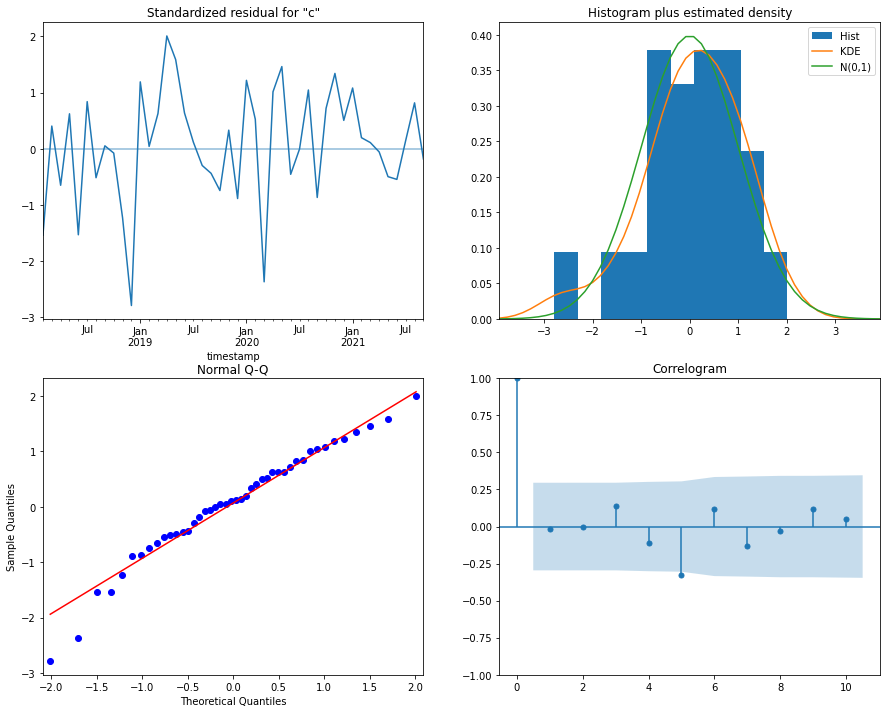

In [26]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [27]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

### 4.2 ARIMA for Bitcoin

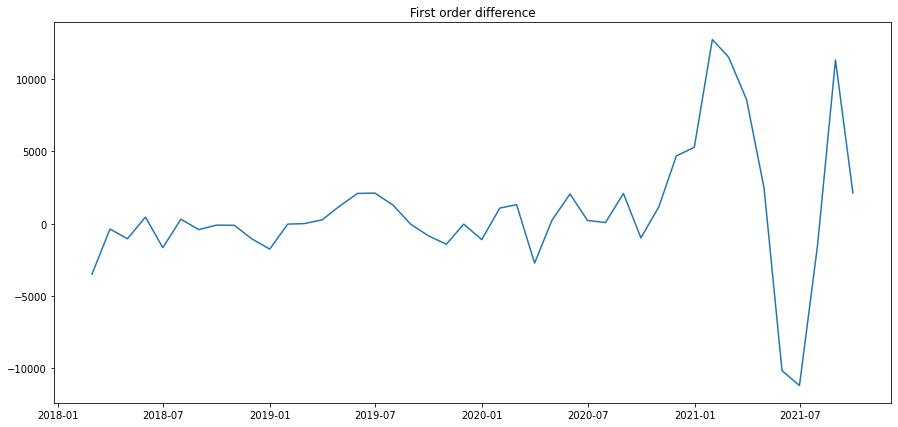

In [28]:
diff1 = btc_month[['Close']].diff()
diff1 = diff1.dropna()
plt.plot(diff1)
plt.title('First order difference')
plt.show()

In [29]:
# ARIMA model
model = ARIMA(btc_month[['Close']],order=(1,1,1))
arima_result = model.fit()
arima_result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52660D+00    |proj g|=  1.09111D-02

At iterate    5    f=  9.52312D+00    |proj g|=  7.46069D-06

At iterate   10    f=  9.52312D+00    |proj g|=  3.98792D-04

At iterate   15    f=  9.52290D+00    |proj g|=  4.74039D-03

At iterate   20    f=  9.52189D+00    |proj g|=  1.74438D-04

At iterate   25    f=  9.52189D+00    |proj g|=  4.97380D-06

At iterate   30    f=  9.52189D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -418.963
Method:                       css-mle   S.D. of innovations           3273.584
Date:                Tue, 01 Feb 2022   AIC                            845.926
Time:                        02:40:53   BIC                            853.063
Sample:                    02-28-2018   HQIC                           848.573
                         - 09-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           558.3945   1028.250      0.543      0.587   -1456.939    2573.728
ar.L1.D.Close     0.2280      0.222      1.027      0.304      -0.207       0.663
ma.L1.D.Close     0.6265      0.228      2.748      0.006       0.180       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3851           +0.0000j            4.3851            0.0000
MA.1           -1.5961           +0.0000j            1.5961            0.5000
-----------------------------------------------------------------------------
"""

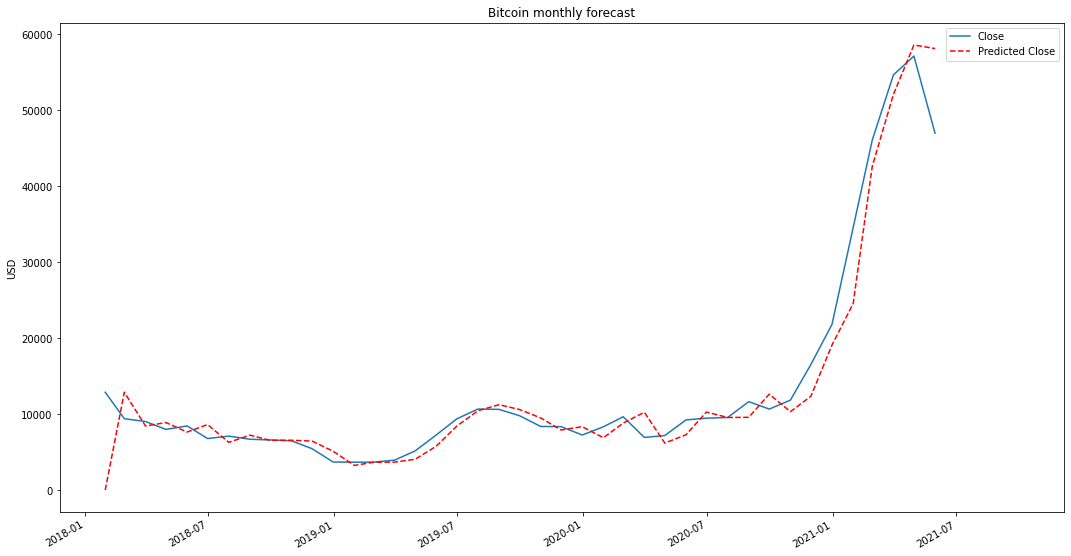

In [30]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2021, 6, 20), datetime(2021, 7, 20), datetime(2021, 8, 21), datetime(2021, 9, 21)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2021, 5, 31)), lmbda)
plt.figure(figsize=(18,10))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

#### Reference
https://en.wikipedia.org/wiki/Cryptocurrency

https://www.investopedia.com/tech/most-important-cryptocurrencies-other-than-bitcoin/

https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition

https://www.kaggle.com/odins0n/g-research-plots-eda

https://www.kaggle.com/taniaj/cryptocurrency-predictions-with-arima

**Special Thanks to Candice** ❤️ !

### Thank you! 谢谢 🙏